## Install dependencies

In [1]:
# !pip install librosa
# !pip install matplotlib
# !pip install seaborn
# !pip install keras
# !pip install tensorflow
# !pip install opencv-contrib-python

In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

2022-05-01 17:45:44.002788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 17:45:44.002806: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Wavelet data generation..

In [2]:
def func(cls):
  img_names = os.listdir('genres/'+cls)
  os.makedirs('wavelets/train/'+cls)
  os.makedirs('wavelets/test/'+cls)
  print(cls)
  train_names = img_names[:60]
  test_names = img_names[60:]
  cnt = 0
  for nm in train_names:
    cnt+=1
    x , sr = librosa.load('genres/'+cls+'/'+nm)
    #plt.figure(figsize=(14, 5))
    librosa.display.waveshow(x)
    plt.savefig('wavelets/train/'+cls+'/'+str(cnt)+'.png')
    plt.close()
  
  cnt = 0
  for nm in test_names:
    cnt+=1
    x , sr = librosa.load('genres/'+cls+'/'+nm)
    #plt.figure(figsize=(14, 5))
    librosa.display.waveshow(x)
    plt.savefig('wavelets/test/'+cls+'/'+str(cnt)+'.png')
    plt.close()

In [3]:
import os
classes = [a for a in os.listdir('genres') if '.' not in a]
print(classes)
cl1 = ['hiphop', 'country', 'disco']
cl2 = ['jazz', 'classical', 'reggae', 'rock']
cl3 = ['pop', 'blues', 'metal']
for i in cl3:
    func(i)

['hiphop', 'country', 'disco', 'pop', 'blues', 'metal', 'jazz', 'classical', 'reggae', 'rock']
pop
blues
metal


## Spectrogram generation..

In [1]:
def func1(cls):
  img_names = os.listdir('genres/'+cls)
  os.makedirs('spectrogram/train/'+cls)
  os.makedirs('spectrogram/test/'+cls)
  print(cls)
  train_names = img_names[:60]
  test_names = img_names[60:]
  cnt = 0
  print('train: ', end = '')

  for nm in train_names:
    cnt+=1
    x , sr = librosa.load('genres/'+cls+'/'+nm)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb)
    plt.savefig('spectrogram/train/'+cls+'/'+str(cnt)+'.png')
    plt.close()
    print(cnt, end=' ')
  
  cnt = 0
  print('\ntest: ', end = '')
  for nm in test_names:
    cnt+=1
    x , sr = librosa.load('genres/'+cls+'/'+nm)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb)
    plt.savefig('spectrogram/test/'+cls+'/'+str(cnt)+'.png')
    plt.close()
    print(cnt, end=' ')


In [2]:
classes = [a for a in os.listdir('genres') if '.' not in a]
cl1 = ['hiphop', 'country']
cl2 = ['jazz', 'classical']
cl3 = ['reggae', 'rock']
cl4 = ['pop', 'blues']
cl5 = ['metal', 'disco']
print(classes)

for i in cl5:
    func1(i)

['hiphop', 'country', 'disco', 'pop', 'blues', 'metal', 'jazz', 'classical', 'reggae', 'rock']
metal
train: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 
test: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 disco
train: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 
test: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 

## Model training..

In [2]:
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
img_size = 256
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [6]:
train = get_data('spectrogram/train')
val = get_data('spectrogram/test')

/tmp/ipykernel_88780/802610576.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [7]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [8]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [9]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.32))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

2022-05-01 13:15:30.586558: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/srm-prodesk/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-05-01 13:15:30.586583: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-01 13:15:30.586602: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (srmprodesk-HP-ProDesk-400-G7-Small-Form-Factor-PC): /proc/driver/nvidia/version does not exist
2022-05-01 13:15:30.587108: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriat

In [10]:
opt = Adam(lr=0.0001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

/home/srm-prodesk/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
history = model.fit(x_train,y_train,epochs = 500, validation_data = (x_val, y_val))

Epoch 1/500


/home/srm-prodesk/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


19/19 [==============================] - 17s 881ms/step - loss: 2.3293 - accuracy: 0.1250 - val_loss: 2.2696 - val_accuracy: 0.1875
Epoch 2/500
19/19 [==============================] - 16s 854ms/step - loss: 2.2283 - accuracy: 0.2133 - val_loss: 2.1333 - val_accuracy: 0.2425
Epoch 3/500
19/19 [==============================] - 16s 858ms/step - loss: 2.0965 - accuracy: 0.2467 - val_loss: 2.0058 - val_accuracy: 0.3275
Epoch 4/500
19/19 [==============================] - 16s 840ms/step - loss: 1.9471 - accuracy: 0.2967 - val_loss: 1.8683 - val_accuracy: 0.3200
Epoch 5/500
19/19 [==============================] - 16s 869ms/step - loss: 1.8438 - accuracy: 0.3133 - val_loss: 1.7708 - val_accuracy: 0.3525
Epoch 6/500
19/19 [==============================] - 16s 838ms/step - loss: 1.7581 - accuracy: 0.3383 - val_loss: 1.7330 - val_accuracy: 0.3600
Epoch 7/500
19/19 [==============================] - 16s 832ms/step - loss: 1.7081 - accuracy: 0.3667 - val_loss: 1.6671 - val_accuracy: 0.4200
Epoc

Epoch 58/500
19/19 [==============================] - 16s 844ms/step - loss: 0.4593 - accuracy: 0.8583 - val_loss: 1.3359 - val_accuracy: 0.5450
Epoch 59/500
19/19 [==============================] - 16s 838ms/step - loss: 0.4718 - accuracy: 0.8550 - val_loss: 1.3437 - val_accuracy: 0.5675
Epoch 60/500
19/19 [==============================] - 16s 839ms/step - loss: 0.4073 - accuracy: 0.8817 - val_loss: 1.4255 - val_accuracy: 0.5575
Epoch 61/500
19/19 [==============================] - 16s 844ms/step - loss: 0.4026 - accuracy: 0.8883 - val_loss: 1.3811 - val_accuracy: 0.5550
Epoch 62/500
19/19 [==============================] - 16s 844ms/step - loss: 0.3711 - accuracy: 0.8883 - val_loss: 1.2976 - val_accuracy: 0.5850
Epoch 63/500
19/19 [==============================] - 16s 838ms/step - loss: 0.3851 - accuracy: 0.8883 - val_loss: 1.3550 - val_accuracy: 0.5625
Epoch 64/500
19/19 [==============================] - 16s 838ms/step - loss: 0.4908 - accuracy: 0.8333 - val_loss: 1.4028 - val_ac

19/19 [==============================] - 16s 844ms/step - loss: 0.0555 - accuracy: 0.9833 - val_loss: 2.3919 - val_accuracy: 0.5575
Epoch 171/500
19/19 [==============================] - 16s 840ms/step - loss: 0.0574 - accuracy: 0.9883 - val_loss: 2.3531 - val_accuracy: 0.5675
Epoch 172/500
19/19 [==============================] - 16s 838ms/step - loss: 0.0313 - accuracy: 0.9950 - val_loss: 2.2202 - val_accuracy: 0.5975
Epoch 173/500
19/19 [==============================] - 16s 839ms/step - loss: 0.0330 - accuracy: 0.9917 - val_loss: 2.4979 - val_accuracy: 0.5650
Epoch 174/500
19/19 [==============================] - 16s 847ms/step - loss: 0.0287 - accuracy: 0.9967 - val_loss: 2.4528 - val_accuracy: 0.5575
Epoch 175/500
19/19 [==============================] - 16s 843ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 2.2651 - val_accuracy: 0.5750
Epoch 176/500
19/19 [==============================] - 16s 838ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 2.2437 - val_accuracy:

19/19 [==============================] - 16s 841ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 2.4178 - val_accuracy: 0.6000
Epoch 283/500
19/19 [==============================] - 16s 839ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.4211 - val_accuracy: 0.6100
Epoch 284/500
19/19 [==============================] - 16s 840ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 2.4056 - val_accuracy: 0.5900
Epoch 285/500
19/19 [==============================] - 16s 837ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 2.4037 - val_accuracy: 0.6000
Epoch 286/500
19/19 [==============================] - 16s 841ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.4228 - val_accuracy: 0.5925
Epoch 287/500
19/19 [==============================] - 16s 847ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.3997 - val_accuracy: 0.5900
Epoch 288/500
19/19 [==============================] - 16s 846ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.4300 - val_accuracy:

19/19 [==============================] - 16s 848ms/step - loss: 6.0118e-04 - accuracy: 1.0000 - val_loss: 2.7392 - val_accuracy: 0.5925
Epoch 394/500
19/19 [==============================] - 16s 844ms/step - loss: 6.1573e-04 - accuracy: 1.0000 - val_loss: 2.7344 - val_accuracy: 0.5950
Epoch 395/500
19/19 [==============================] - 16s 845ms/step - loss: 6.0919e-04 - accuracy: 1.0000 - val_loss: 2.7078 - val_accuracy: 0.5925
Epoch 396/500
19/19 [==============================] - 16s 842ms/step - loss: 5.5778e-04 - accuracy: 1.0000 - val_loss: 2.7132 - val_accuracy: 0.5950
Epoch 397/500
19/19 [==============================] - 16s 841ms/step - loss: 5.9462e-04 - accuracy: 1.0000 - val_loss: 2.7268 - val_accuracy: 0.5925
Epoch 398/500
19/19 [==============================] - 16s 841ms/step - loss: 6.1925e-04 - accuracy: 1.0000 - val_loss: 2.7259 - val_accuracy: 0.5900
Epoch 399/500
19/19 [==============================] - 16s 846ms/step - loss: 7.1098e-04 - accuracy: 1.0000 - val_

Epoch 448/500
19/19 [==============================] - 16s 847ms/step - loss: 4.5713e-04 - accuracy: 1.0000 - val_loss: 2.8616 - val_accuracy: 0.6025
Epoch 449/500
19/19 [==============================] - 16s 842ms/step - loss: 3.6757e-04 - accuracy: 1.0000 - val_loss: 2.8703 - val_accuracy: 0.6000
Epoch 450/500
19/19 [==============================] - 16s 845ms/step - loss: 3.5258e-04 - accuracy: 1.0000 - val_loss: 2.8749 - val_accuracy: 0.6000
Epoch 451/500
19/19 [==============================] - 16s 845ms/step - loss: 3.7885e-04 - accuracy: 1.0000 - val_loss: 2.8966 - val_accuracy: 0.5975
Epoch 452/500
19/19 [==============================] - 16s 840ms/step - loss: 3.2050e-04 - accuracy: 1.0000 - val_loss: 2.8818 - val_accuracy: 0.5900
Epoch 453/500
19/19 [==============================] - 16s 840ms/step - loss: 3.2507e-04 - accuracy: 1.0000 - val_loss: 2.9018 - val_accuracy: 0.6025
Epoch 454/500
19/19 [==============================] - 16s 838ms/step - loss: 3.4072e-04 - accuracy:

In [9]:
import pickle
model.save_weights('500_epoch_simple_lr.cpkt')

pickle.dump(history.history, open('history_500_epoch_simple.pkl','wb'))

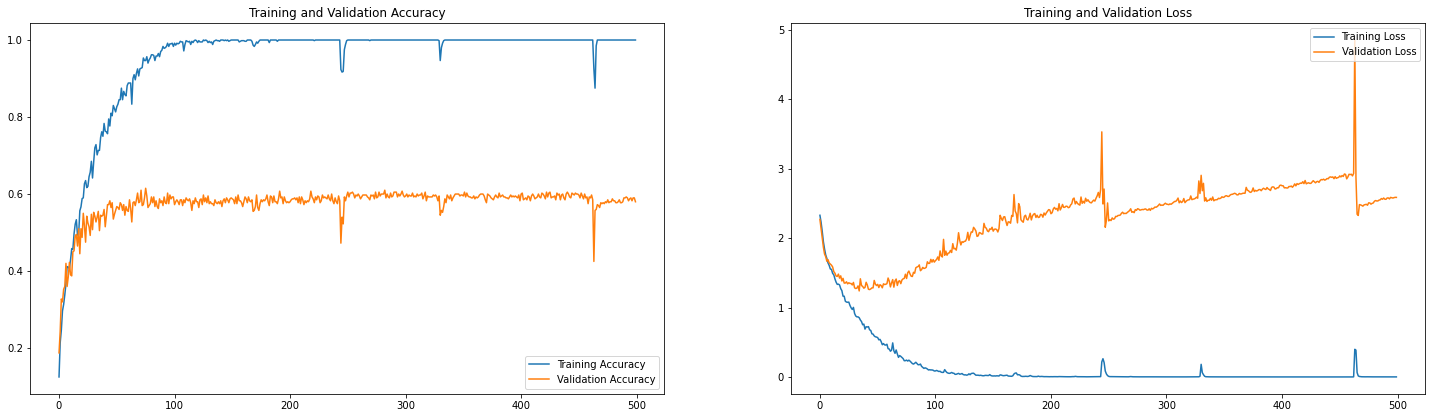

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
import pickle
history = pickle.load(open('history_500_epoch_simple.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('sim_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1080x432 with 0 Axes>

In [12]:
predictions = model.predict(x_val)
print(len(y_val))
predictions = predictions.reshape(1,-1)[0]
# print(classification_report(y_val, predictions, target_names = labels))

400


In [13]:
print(len(y_val), len(predictions))

400 4000


In [14]:
# import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt
# cm1 = confusion_matrix(y_val, predictions)
# df_cm = pd.DataFrame(cm1, index = [i for i in labels],
#               columns = [i for i in labels])
# plt.figure(figsize = (10,7))
# sn.heatmap(df_cm, annot=True,cmap="RdPu")
# plt.savefig('confusion_mrtx1.png',bbox_inches = 'tight')

# Transfer Learning based modeling

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")

In [16]:
base_model.trainable = False
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(10, activation="softmax")                                     
                                ])

In [17]:
base_learning_rate = 0.0007
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history1 = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val))

Epoch 1/500
19/19 [==============================] - 13s 625ms/step - loss: 2.2952 - accuracy: 0.1683 - val_loss: 1.9888 - val_accuracy: 0.2900
Epoch 2/500
19/19 [==============================] - 11s 599ms/step - loss: 1.9600 - accuracy: 0.2817 - val_loss: 1.7522 - val_accuracy: 0.3950
Epoch 3/500
19/19 [==============================] - 11s 608ms/step - loss: 1.7162 - accuracy: 0.3767 - val_loss: 1.6275 - val_accuracy: 0.4400
Epoch 4/500
19/19 [==============================] - 11s 614ms/step - loss: 1.5926 - accuracy: 0.4500 - val_loss: 1.5493 - val_accuracy: 0.4775
Epoch 5/500
19/19 [==============================] - 12s 627ms/step - loss: 1.5067 - accuracy: 0.4650 - val_loss: 1.4951 - val_accuracy: 0.5050
Epoch 6/500
19/19 [==============================] - 11s 601ms/step - loss: 1.4768 - accuracy: 0.4650 - val_loss: 1.4498 - val_accuracy: 0.5050
Epoch 7/500
19/19 [==============================] - 11s 587ms/step - loss: 1.4024 - accuracy: 0.5033 - val_loss: 1.4173 - val_accuracy:

19/19 [==============================] - 11s 594ms/step - loss: 0.4879 - accuracy: 0.8667 - val_loss: 0.9929 - val_accuracy: 0.6650
Epoch 114/500
19/19 [==============================] - 11s 583ms/step - loss: 0.4807 - accuracy: 0.8633 - val_loss: 0.9931 - val_accuracy: 0.6675
Epoch 115/500
19/19 [==============================] - 11s 581ms/step - loss: 0.4668 - accuracy: 0.8783 - val_loss: 0.9961 - val_accuracy: 0.6625
Epoch 116/500
19/19 [==============================] - 11s 582ms/step - loss: 0.4757 - accuracy: 0.8883 - val_loss: 0.9990 - val_accuracy: 0.6600
Epoch 117/500
19/19 [==============================] - 11s 586ms/step - loss: 0.4567 - accuracy: 0.8733 - val_loss: 0.9995 - val_accuracy: 0.6550
Epoch 118/500
19/19 [==============================] - 11s 586ms/step - loss: 0.4649 - accuracy: 0.8800 - val_loss: 1.0023 - val_accuracy: 0.6700
Epoch 119/500
19/19 [==============================] - 11s 585ms/step - loss: 0.4597 - accuracy: 0.8767 - val_loss: 0.9931 - val_accuracy:

19/19 [==============================] - 11s 604ms/step - loss: 0.2879 - accuracy: 0.9433 - val_loss: 1.0219 - val_accuracy: 0.6700
Epoch 226/500
19/19 [==============================] - 11s 598ms/step - loss: 0.2977 - accuracy: 0.9300 - val_loss: 1.0195 - val_accuracy: 0.6625
Epoch 227/500
19/19 [==============================] - 11s 591ms/step - loss: 0.3195 - accuracy: 0.9150 - val_loss: 1.0259 - val_accuracy: 0.6675
Epoch 228/500
19/19 [==============================] - 11s 594ms/step - loss: 0.2974 - accuracy: 0.9333 - val_loss: 1.0202 - val_accuracy: 0.6850
Epoch 229/500
19/19 [==============================] - 11s 594ms/step - loss: 0.2938 - accuracy: 0.9333 - val_loss: 1.0291 - val_accuracy: 0.6475
Epoch 230/500
19/19 [==============================] - 11s 588ms/step - loss: 0.3142 - accuracy: 0.9233 - val_loss: 1.0222 - val_accuracy: 0.6650
Epoch 231/500
19/19 [==============================] - 11s 591ms/step - loss: 0.2870 - accuracy: 0.9183 - val_loss: 1.0207 - val_accuracy:

19/19 [==============================] - 11s 589ms/step - loss: 0.2207 - accuracy: 0.9483 - val_loss: 1.0763 - val_accuracy: 0.6650
Epoch 338/500
19/19 [==============================] - 11s 590ms/step - loss: 0.2275 - accuracy: 0.9467 - val_loss: 1.0725 - val_accuracy: 0.6650
Epoch 339/500
19/19 [==============================] - 11s 592ms/step - loss: 0.2078 - accuracy: 0.9550 - val_loss: 1.0748 - val_accuracy: 0.6575
Epoch 340/500
19/19 [==============================] - 11s 587ms/step - loss: 0.2202 - accuracy: 0.9467 - val_loss: 1.0794 - val_accuracy: 0.6625
Epoch 341/500
19/19 [==============================] - 11s 578ms/step - loss: 0.2156 - accuracy: 0.9500 - val_loss: 1.0840 - val_accuracy: 0.6575
Epoch 342/500
19/19 [==============================] - 11s 579ms/step - loss: 0.2073 - accuracy: 0.9600 - val_loss: 1.0818 - val_accuracy: 0.6675
Epoch 343/500
19/19 [==============================] - 11s 578ms/step - loss: 0.2180 - accuracy: 0.9583 - val_loss: 1.0804 - val_accuracy:

19/19 [==============================] - 11s 592ms/step - loss: 0.1798 - accuracy: 0.9550 - val_loss: 1.1652 - val_accuracy: 0.6500
Epoch 450/500
19/19 [==============================] - 11s 593ms/step - loss: 0.1639 - accuracy: 0.9633 - val_loss: 1.1435 - val_accuracy: 0.6600
Epoch 451/500
19/19 [==============================] - 11s 596ms/step - loss: 0.1676 - accuracy: 0.9750 - val_loss: 1.1449 - val_accuracy: 0.6550
Epoch 452/500
19/19 [==============================] - 11s 594ms/step - loss: 0.1882 - accuracy: 0.9500 - val_loss: 1.1450 - val_accuracy: 0.6575
Epoch 453/500
19/19 [==============================] - 11s 593ms/step - loss: 0.1645 - accuracy: 0.9683 - val_loss: 1.1353 - val_accuracy: 0.6675
Epoch 454/500
19/19 [==============================] - 11s 602ms/step - loss: 0.1683 - accuracy: 0.9683 - val_loss: 1.1385 - val_accuracy: 0.6575
Epoch 455/500
19/19 [==============================] - 11s 594ms/step - loss: 0.1599 - accuracy: 0.9783 - val_loss: 1.1576 - val_accuracy:

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


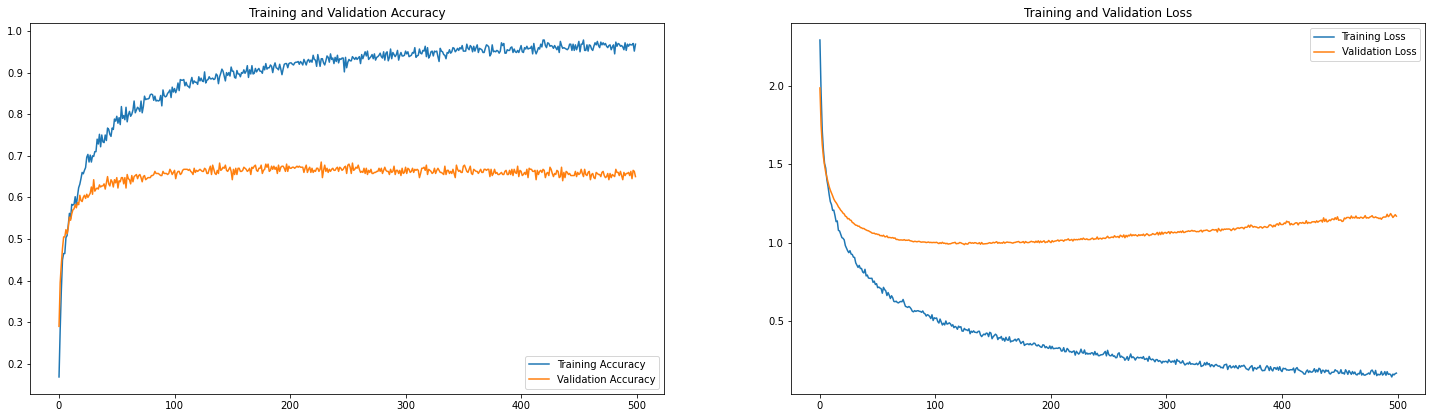

In [19]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
import pickle
model.save_weights('500_epoch_simple_lr.cpkt')

pickle.dump(history1.history, open('history_500_epoch_tr.pkl','wb'))

In [21]:
import pickle
history = pickle.load(open('history_500_epoch_tr.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1080x432 with 0 Axes>

In [22]:
# predictions = model.predict(x_val)
# predictions = predictions.reshape(1,-1)[0]
# print(classification_report(y_val, predictions, target_names = labels))

predictions = model.predict(x_val)
print(len(y_val))
predictions = predictions.reshape(1,-1)[0]

400


In [23]:
# import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt
# cm1 = confusion_matrix(y_val, predictions)
# df_cm = pd.DataFrame(cm1, index = [i for i in labels],
#               columns = [i for i in labels])
# plt.figure(figsize = (10,7))
# sn.heatmap(df_cm, annot=True,cmap="RdPu")
# plt.savefig('confusion_mrtx2.png',bbox_inches = 'tight')

In [24]:
model.save_weights('500_epoch_transfer_lr.cpkt')
pickle.dump(history1.history, open('history_500_epoch_tr.pkl','wb'))